In [1]:
import pandas as pd
import numpy as np 
from torch import nn
import torch
from torchtext import data
from torch.nn  import functional as F
import torch.optim as  optim 
df = pd.read_csv("data/arabic_english.txt",delimiter="\t",names=["eng","ar"])
df

,eng,ar
0,Hi.,مرحبًا.
1,Run!,اركض!
2,Help!,النجدة!
3,Jump!,اقفز!
4,Stop!,قف!
...,...,...
24633,rising voices promoting a more linguistically ...,شاركنا تحدي ابداع ميم بلغتك الام تعزيزا للتنوع...
24634,following last year s successful campaign we i...,استكمالا لنجاح حملة العام السابق ندعوكم للمشار...
24635,during last year s challenge we also met langu...,تعرفنا خلال تحدي العام الماضي على ابطال لغويين...
24636,to take part just follow the simple steps outl...,للمشاركة في التحدي اتبع الخطوات الموضحة على ال...


In [3]:
!python -m spacy download en_core_web_sm

^C


2021-08-02 19:25:49.351709: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library cudart64_110.dll


✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')


In [2]:
import math
import pandas as pd
import math
import pandas as pd
import torchtext
import torch
import torch.nn as nn
import random
import re
import spacy
from torchtext import data
from spacy.tokenizer import Tokenizer
from spacy.lang.en import English
from spacy.lang.ar import Arabic
from nltk.translate.bleu_score import sentence_bleu
from torchtext.data.utils import get_tokenizer
from collections import Counter
from torchtext.vocab import Vocab
from torch import Tensor


seed=32
df = pd.read_csv("data/arabic_english.txt",delimiter="\t",names=["eng","ar"])

'''
First :
python -m spacy download en_core_web_sm
'''
spacy_eng = spacy.load("en_core_web_sm")

arab = Arabic()
ar_Tokenizer = Tokenizer(arab.vocab)

def engTokenizer(text):
 return  [word.text for word in spacy_eng.tokenizer(text)] 

def arTokenizer(sentence):
    return  [word.text for word in 
             ar_Tokenizer(re.sub(r"\s+"," ",re.sub(r"[\.\'\"\n+]"," ",sentence)).strip())]

SRC = data.Field(tokenize=engTokenizer,batch_first=False,init_token="<sos>",eos_token="<eos>")
TRG = data.Field(tokenize=arTokenizer,batch_first=False,tokenizer_language="ar",init_token="بداية",eos_token="نهاية")

class TextDataset(data.Dataset):

    def __init__(self, df, src_field, target_field, is_test=False, **kwargs):
        fields = [('eng', src_field), ('ar',target_field)]
        samples = []
        for i, row in df.iterrows():
            eng = row.eng 
            ar = row.ar
            samples.append(data.Example.fromlist([eng, ar], fields))

        super().__init__(samples, fields, **kwargs)
    def __len__(self):
        return len(self.samples)
        
    def __getitem__(self, idx):
        return self.samples[idx]

torchdataset = TextDataset(df,SRC,TRG)

train_data, valid_data = torchdataset.split(split_ratio=0.8, random_state = random.seed(32))

SRC.build_vocab(train_data,min_freq=2)
TRG.build_vocab(train_data,min_freq=2)

print(TRG.vocab.freqs.most_common(10))  




[('في', 10140), ('من', 8760), ('على', 5248), ('ان', 2553), ('عن', 2310), ('العالمية', 2261), ('الاصوات', 2195), ('الى', 1826), ('هذا', 1619), ('لا', 1595)]


In [3]:
print(train_data[1].__dict__)

{'eng': ['I', 'was', 'delayed', 'by', 'a', 'traffic', 'jam', '.'], 'ar': ['أخّرني', 'زحام', 'السير']}


In [4]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [5]:
BATCH_SIZE = 16

train_iter, valid_iter = data.BucketIterator.splits(
    (train_data,valid_data), 
    batch_size = BATCH_SIZE,
    sort=None,
    sort_within_batch=False,
    sort_key=lambda x: len(x.eng),
    device = device,
    shuffle=True
)

In [6]:
class Transformer(nn.Module):
    def __init__(
        self,
        embedding_size,
        src_vocab_size,
        trg_vocab_size,
        src_pad_idx,
        num_heads,
        num_encoder_layers,
        num_decoder_layers,
        forward_expansion,
        dropout,
        max_len,
        device,
    ):
        super(Transformer, self).__init__()
        self.src_embeddings = nn.Embedding(src_vocab_size,embedding_size)
        self.src_positional_embeddings= nn.Embedding(max_len,embedding_size)
        self.trg_embeddings= nn.Embedding(trg_vocab_size,embedding_size)
        self.trg_positional_embeddings= nn.Embedding(max_len,embedding_size)
        self.device = device
        self.transformer = nn.Transformer(
            embedding_size,
            num_heads,
            num_encoder_layers,
            num_decoder_layers,
            forward_expansion,
            dropout,
        )

        self.fc_out = nn.Linear(embedding_size, trg_vocab_size)
        self.dropout = nn.Dropout(dropout)
        self.src_pad_idx = src_pad_idx
    
    def make_src_mask(self, src):
        src_mask = src.transpose(0,1) == self.src_pad_idx

        return src_mask

    def forward(self,src,trg):
        src_seq_length, S = src.shape
        trg_seq_length, S = trg.shape
        #adding zeros is an easy way
        src_positions = (
            torch.arange(0, src_seq_length).unsqueeze(1).expand(src_seq_length, S).to(self.device)
        )
        
        
        trg_positions = (
            torch.arange(0, trg_seq_length).unsqueeze(1).expand(trg_seq_length, S).to(self.device)
        )

        embed_src  = self.dropout(
                ( self.src_embeddings(src) + self.src_positional_embeddings(src_positions) )
            )

        embed_trg = self.dropout(
                ( self.trg_embeddings(trg) + self.trg_positional_embeddings(trg_positions) )
            )
        
        src_padding_mask = self.make_src_mask(src)
        trg_mask = self.transformer.generate_square_subsequent_mask(trg_seq_length).to(device)
        
        
        out = self.transformer(embed_src,embed_trg, src_key_padding_mask=src_padding_mask,tgt_mask=trg_mask )
        out= self.fc_out(out)

        return out

In [7]:
load_model = False
save_model = True

num_epochs = 40
learning_rate = 0.0003

num_heads = 8
num_encoder_layers = 3
num_decoder_layers = 3

max_len= 230
dropout = 0.10
embedding_size= 256
src_pad_idx = SRC.vocab.stoi["<pad>"]
forward_expansion = 4
step = 0


src_vocab_size  = len(SRC.vocab)
print("Size of english vocabulary:",src_vocab_size)

#No. of unique tokens in label
trg_vocab_size =len(TRG.vocab)
print("Size of arabic vocabulary:",trg_vocab_size)


model = Transformer(        
    embedding_size,
    src_vocab_size,
    trg_vocab_size,
    src_pad_idx,
    num_heads,
    num_encoder_layers,
    num_decoder_layers,
    forward_expansion,
    dropout,
    max_len,
    device,
).to(device)

Size of english vocabulary: 12812
Size of arabic vocabulary: 22067


In [8]:
import torch
torch.cuda.empty_cache()

In [9]:
loss_track = []
loss_validation_track= []


optimizer = optim.Adam(model.parameters(), lr=learning_rate)

pad_idx = SRC.vocab.stoi["<pad>"]
criterion = nn.CrossEntropyLoss(ignore_index = pad_idx)
for epoch in range(num_epochs):
    stepLoss=[]
    model.train()
    for batch  in train_iter:
        input_data = batch.eng.to(device)
        target = batch.ar.to(device)

        output = model(input_data,target[:-1])
        optimizer.zero_grad()
        
        output = output.reshape(-1,trg_vocab_size)
        target = target[1:].reshape(-1)

        loss = criterion(output,target)
        loss.backward()

        optimizer.step()
        stepLoss.append(loss.item())

    loss_track.append(np.mean(stepLoss))
    print("train crossentropy at epoch {} loss: ".format(epoch),np.mean(stepLoss))

    with torch.no_grad():    
      stepValidLoss=[]
      model.eval() # the evaluation mode for the model (doesn't apply dropout and batchNorm)
      for i,batch  in enumerate(valid_iter):
            input_sentence = batch.eng.to(device)
            target = batch.ar.to(device)
            optimizer.zero_grad()
            output = model(input_sentence,target[:-1])
            output = output.reshape(-1,trg_vocab_size)
            target = target[1:].reshape(-1)
            loss = criterion(output,target)
                  
            stepValidLoss.append(loss.item())
    
    loss_validation_track.append(np.mean(stepValidLoss))
    print("validation crossentropy at epoch {} loss: ".format(epoch),np.mean(stepValidLoss))   
  

train crossentropy at epoch 0 loss:  7.37209430801404
validation crossentropy at epoch 0 loss:  5.882510018813146
train crossentropy at epoch 1 loss:  6.8122590698979115
validation crossentropy at epoch 1 loss:  5.611869099852327
train crossentropy at epoch 2 loss:  6.395553330709408
validation crossentropy at epoch 2 loss:  5.4172646124641615
train crossentropy at epoch 3 loss:  5.939895165818078
validation crossentropy at epoch 3 loss:  5.204577690595157
train crossentropy at epoch 4 loss:  5.4625384387644855
validation crossentropy at epoch 4 loss:  5.152939149311611
train crossentropy at epoch 5 loss:  4.995478682123221
validation crossentropy at epoch 5 loss:  5.007746482050264
train crossentropy at epoch 6 loss:  4.52979467035114
validation crossentropy at epoch 6 loss:  4.984653910259148
train crossentropy at epoch 7 loss:  4.094301900112784
validation crossentropy at epoch 7 loss:  4.97205556987168
train crossentropy at epoch 8 loss:  3.6891164866747794
validation crossentropy 

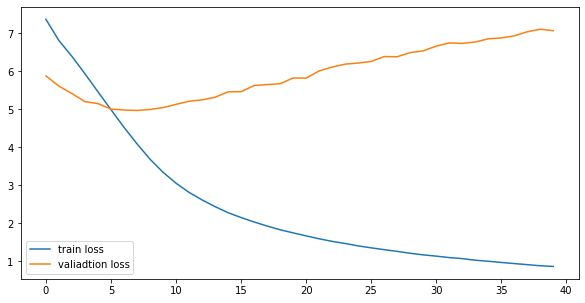

In [10]:
import matplotlib.pyplot as plt 

#the train loss after 50 epoch
plt.figure(figsize=(10,5))
plt.plot(range(40),loss_track,label="train loss")
plt.plot(range(40),loss_validation_track,label="valiadtion loss")
plt.legend()
plt.show()

In [11]:
def translate_sentence(model,sentence,srcField,targetField,srcTokenizer):
    model.eval()
    processed_sentence = srcField.process([srcTokenizer(sentence)]).to(device)
    trg = ["بداية"]

    for _ in range(60):
        trg_indecies = [targetField.vocab.stoi[word] for word in trg]
        trg_tensor = torch.LongTensor(trg_indecies).unsqueeze(1).to(device)
        outputs = model(processed_sentence,trg_tensor)
        
        if targetField.vocab.itos[outputs.argmax(2)[-1:].item()] == "<unk>":
            continue 
        trg.append(targetField.vocab.itos[outputs.argmax(2)[-1:].item()])
        if targetField.vocab.itos[outputs.argmax(2)[-1:].item()] == "نهاية":
            break
    return " ".join([word for word in trg if word != "<unk>"][1:-1])


In [23]:
translate_sentence(model,"I'm ready" ,SRC,TRG,engTokenizer)

'أنا مستعد'